# Particle Simulation System

### Introduction

Causal Structure Discovery is the problem of identifying causal relationships from large quantities of data through computational methods. Causal relations cannot be read directly from a data sample, they can only be inferred. For any given system only an understanding of the underlying causal relations can support predictions about how a system will behave when it is subject to intervention. Causal discovery has wide range of applications from climate modeling, social dynamics to biological systems modeling. Time series data play a crucial role in Causal Structure Discovery. In time-series, the assumption that causes temporrally precede thier effect enable us to discover causal relations in observational data. This article is written in an attempt to understand the causal structure discovery through the paper <b>Dynamic relational inference in multi-agent trajectories</b>. In this article we will study the recent works done in causal discovery and implement a computational model to study and infer model's behaviour. We will first formally define the problem then explore methods of disovery. We will also implement a simple linear regression based model to predict the causal interaction between elements of a system.

### Modelling causal graph as a particle spring system

We will first formally define a causal structure as a graph $G$ which is described by variables $V$ and edges $E$. Variables $V$ can also be represented as nodes in a graph. Each node or variable $v \subset V$. nodes in a graph interacts with all other nodes through edges $e \subset E$. Together with $V$ and $E$ we can define a causal structure graph as $G=\{V, E\}$

A node or a variable in a graph can be represented by $n$ number of features and they can be represented as $ v = \{x_1, x_2, ...., x_n\}$. In a dynamic setting both variables and the underlying causal structure can vary over time. Since, the variables and causal structure/graph changes over time we can capture these dynamics as a time series data. Given a time series data we can model the system under a linear or non linear granger causality. According to Granger causality, if a variable $x_1$ "Granger-causes" $x_2$, then past values of $x_1$ should contain information that helps predict $x_2$ above and beyond the information contained in past values of $x_2$ alone.

\begin{equation*}
x^{t+1}_{j} = g_{j}(x^{\leq t}_1, ..., x^{\leq t}_n) + \epsilon^{t}_j
\end{equation*}

where $x^{t+1}_{j}$ denotes present and past series $j$ and $\epsilon^{t}_j$ represents independent noise

In this section we will understand how we can model the causaulity for a time series data generated for a particle system. Let us consider a two dimension square box with $P$ particles and these particles can be considers as nodes or variables as defined in the previous section. These $P$ particles will interact with each other through $P-1$ edges which can be modelled as a causal graph $G=\{V, E\}$. We can visulize the edges $E$ as mechanical spring with elastic coefficient as $e_{i, j}$ where $e_{i, j}$ represents the magnitude of interaction between particle i and particle j. Since, these particles are interating we can take snap shots of thier dynamics through time. $D=\{G^{\leq t}_1, ..., G^{\leq t}_n\}$ and if we represent trajectories as s.
\begin{equation*}
G^{1:T}_{s} = \{V^{1:T}_{s}, E^{1:T}_{s}\}
\end{equation*}

We have already created a data for this modelling so we can visualize it. First lets load all the data and split them into training and testing data set. In this example we have considers a system with $2$ nodes and $1$ edge. These particles move through space and time. Their potential energy and kinetic energy are defined thier velocity and the underlying causal graph. 


In [1]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data 
schema = pd.read_pickle('data_schema.pkl')
data = pd.read_pickle('dyari.pkl')
train = data.sample(frac=0.8, random_state=200)
test = data.drop(train.index)

# Print data schema
print(schema)

                                                       descriptions  \
label                                                                 
positions         Positions of all particles in x and y co ordin...   
velocity          Velocity of all particles in x and y co ordina...   
edges             Causal relationship between particles (spring)...   
kinetic_energy         Kinetic energy of all particles through time   
potential_energy     Potential energy of all particles through time   
total_energy             Total energy of all particles through time   

                                                         dimensions  
label                                                                
positions         (total_trajectories, total_time, 2, num_of_par...  
velocity          (total_trajectories, total_time, 2, num_of_par...  
edges             (total_trajectories, total_time, num_of_partic...  
kinetic_energy                  (total_trajectories, total_time, 1)  
potential_e

Lets pick a random trajectory and print position, velocity and causality matrix of all particles through time.
causality matrix captures interaction dynamics between all particles and it is represented as $nxn$ matrix where $n$ in number of particles.

In [5]:
# Lets pick one simulatated trajectory and analyze it
simulation_sample = train.iloc[0]

# For this simulation sample, lets get all positions
positions = simulation_sample.trajectories.positions
velocities = simulation_sample.trajectories.velocity
edges = simulation_sample.trajectories.edges

# Lets inspect elements at time step 0
time_step = 0

print('------------------------------------------')
print('position of all particles at time step 0')
print('------------------------------------------')
print(positions[time_step], '\n')

print('------------------------------------------')
print('velocity of all particles at time step 0')
print('------------------------------------------')
print(velocities[time_step], '\n')

print('------------------------------------------')
print('causality matrix of all particles at time step 0')
print('------------------------------------------')
print(edges[time_step])

------------------------------------------
position of all particles at time step 0
------------------------------------------
             particle_0  particle_1  particle_2  particle_3  particle_4
x_cordinate    0.490691   -0.525630    0.184509    0.771889   -0.275404
y_cordinate    0.831613   -0.008958    0.335005    0.616859    0.033248 

------------------------------------------
velocity of all particles at time step 0
------------------------------------------
             particle_0  particle_1  particle_2  particle_3  particle_4
x_cordinate    0.057919    0.156626   -0.182934   -0.082343   -0.480486
y_cordinate    0.496634    0.474835   -0.465333   -0.493173    0.138323 

------------------------------------------
causality matrix of all particles at time step 0
------------------------------------------
            particle_0  particle_1  particle_2  particle_3  particle_4
particle_0         0.0         1.0         0.7         0.5         0.7
particle_1         1.0         0.

## Visualizing the model particle spring system

It would be better if we can visualize the trajectory, we can plot the particles trajectory throught time and also we can peek into thier causal interactions.

(-5.0, 5.0)

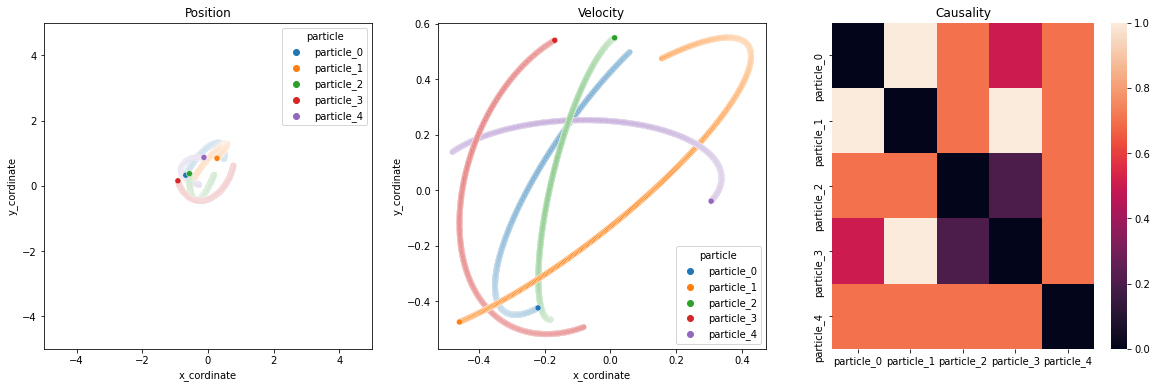

In [6]:
particle_positions = []
for position in simulation_sample.trajectories.positions:
    for particle_id in position.columns:
        particle_positions.append({
            'x_cordinate': position[particle_id]['x_cordinate'],
            'y_cordinate': position[particle_id]['y_cordinate'],
            'particle': particle_id
        })
position_dframe = pd.DataFrame(particle_positions)


particle_velocity = []
for position in simulation_sample.trajectories.velocity:
    for particle_id in position.columns:
        particle_velocity.append({
            'x_cordinate': position[particle_id]['x_cordinate'],
            'y_cordinate': position[particle_id]['y_cordinate'],
            'particle': particle_id
        })
velocity_dframe = pd.DataFrame(particle_velocity)


edges = simulation_sample.trajectories.edges
last_edges = edges[0]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False, sharex=False)
axes[0].set_title('Position')
axes[1].set_title('Velocity')
axes[2].set_title('Causality')
simulation_sample = train.iloc[0]
pl = sns.scatterplot(data=position_dframe, x='x_cordinate', y='y_cordinate', hue='particle', ax=axes[0])
sns.scatterplot(data=velocity_dframe, x='x_cordinate', y='y_cordinate', hue='particle', ax=axes[1])
plh = sns.heatmap(last_edges, vmin=0, vmax=1, ax=axes[2])
pl.set_ylim(-5.0, 5.0)
pl.set_xlim(-5.0, 5.0)

In the above plots we can see the trajectory of two particles over time and we can also see how their velocity changes. The last plot captures causal matrix or interaction matix between particles at time step 0. But as we mentioned the causal interaction graph can change over time. In the data generated for this example the causal interaction graph changes at some random time instance $t$ and we can visually determine it by taking a look at the total energy graph. total enegry of individual particles is determined by the sum of thier potential and kinectic enegery.

<AxesSubplot:xlabel='time_step', ylabel='total_energy'>

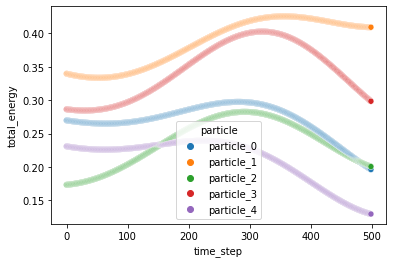

In [7]:
total_energy = []
time_step = 0
for position in simulation_sample.trajectories.total_energy:
    for particle_id in position.columns:
        total_energy.append({
            'total_energy': position[particle_id]['total_energy'],
            'particle': particle_id,
            'time_step': time_step
        })
    time_step += 1
energy_dframe = pd.DataFrame(total_energy)
sns.scatterplot(data=energy_dframe, x='time_step', y='total_energy', hue='particle')

In the above plot we can see that around time step $30$ there is a change in the underlying causal interaction matrix.  In any autoregression it is vital to study autocorrelation as it can give us insight how the current data at time step $t$ is correleated to the data at the previous time steps. 

------- pearson correlation -------
          t-1       t+1
t-1  1.000000  0.999952
t+1  0.999952  1.000000
-----------------------------------


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

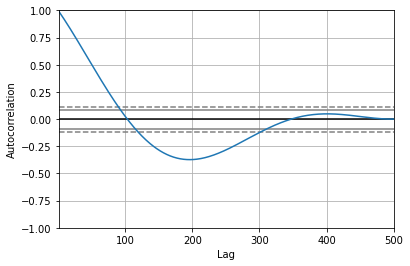

In [8]:
pos = energy_dframe.set_index('time_step')
edf = pos[pos.particle=='particle_0'].total_energy
_df = pd.concat([edf.shift(1), edf], axis=1)
_df.columns = ['t-1', 't+1']
result = _df.corr()
print("------- pearson correlation -------")
print(result)
print("-----------------------------------")

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(edf)

In the autocorrelation plot we can also confirm that the correlation drops as we move back in time and roughly around the time where the causality changes we see changes in the autocorrelation.

## Simple linear regression model for causal discovery

In this section we will implement a simple linear model to predict the underlying given a dynamics of $t$ timesteps.
We will be considering particles positions, velocity in x cordinate, y cordinate along with total_energy as features.

In [9]:
positions = simulation_sample.trajectories.positions
velocities = simulation_sample.trajectories.velocity
energy = simulation_sample.trajectories.total_energy

batch = []
for time_step in range(0, 4):
    frames = [positions[time_step], velocities[time_step], energy[time_step]]
    result = pd.concat(frames)
    batch.append(result)
d = np.asarray(batch)

# one sample of data
print(d.shape)

(4, 5, 5)


Next We will build a simple model to capture particle dynamics

In [10]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

dtype = torch.float
device = torch.device("cpu")
time_slice = 4
particles = 5
features = 5
trajectory_length = 1000
sample_freq = 10

class Data:
    def __init__(self, batch_size=1, time_lag=4):
        self.data = pd.read_pickle('dyari.pkl')
        self.train = self.data.sample(frac=0.8, random_state=200)
        self.test = self.data.drop(self.train.index)
        self.batch_size = batch_size
        self.time_lag = time_lag
        self.trajectory_length = trajectory_length

    def get_batch(self, mode='train'):
        if mode == 'train':
            trajectory_ids = random.sample(range(0, len(self.train)), self.batch_size)
            simulation_samples = self.train.iloc[trajectory_ids]
        else:
            trajectory_ids = random.sample(range(0, len(self.test)), self.batch_size)
            simulation_samples = self.test.iloc[trajectory_ids]

        batch_x = []
        batch_y = []

        def lag_batch(_positions, _velocity, _energy, _edges):
            time_lag = random.randint(self.time_lag, (self.trajectory_length/sample_freq))
            _bx = []
            _by = []
            for time_step in range(time_lag-self.time_lag, time_lag):
                frames = [_positions[time_step], _velocity[time_step], _energy[time_step]]
                result = pd.concat(frames)
                _bx.append(result)
                _by.append(_edges[time_step])
            _by = [_by[-1]]
            return np.asarray(_bx), np.asarray(_by)

        for _id in range(0, len(simulation_samples)):
            _positions = simulation_samples.trajectories[_id].positions
            _velocity = simulation_samples.trajectories[_id].velocity
            _energy = simulation_samples.trajectories[_id].total_energy
            _edges = simulation_samples.trajectories[_id].edges
            _x, _y = lag_batch(_positions, _velocity, _energy, _edges)
            batch_x.append(_x)
            batch_y.append(_y)

        return np.asarray(batch_x), np.asarray(batch_y)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(particles, 10)
        self.fc2 = torch.nn.Linear(10, features)
        self.cn1 = torch.nn.Conv2d(time_slice, 1, 1, stride=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.cn1(x)
        return x

class Model:
    def __init__(self):
        self.net = Net()
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.SGD(self.net.parameters(),
                                         lr=0.001,
                                         momentum=0.9)

    def loss(self, y_prediction, y_real):
        loss = self.criterion(y_prediction, y_real)
        return loss

    def print_params(self, x):
        for param in self.net.parameters():
            print(param)

    def predict(self, x):
        return self.net.forward(torch.from_numpy(x).float())

    def train(self):
        d = Data(batch_size=5, time_lag=time_slice)
        entry = []
        for step in range(1000):
            x_train, target_train = d.get_batch(mode='train')
            x_test, target_test = d.get_batch(mode='test')
            train_loss = self.loss(y_prediction=self.predict(x_train),
                                   y_real=torch.from_numpy(target_train).float())
            test_loss = self.loss(y_prediction=self.predict(x_test),
                                  y_real=torch.from_numpy(target_test).float())
            # print(f'step {step}: {train_loss.item()}, {test_loss.item()}')

            self.optimizer.zero_grad()
            train_loss.backward()
            self.optimizer.step()

            entry.append({'time_step': step, 'loss': train_loss.item(), 'type': 'train'})
            entry.append({'time_step': step, 'loss': test_loss.item(), 'type': 'test'})
        
        return entry

Lets initialize this model and start training

In [11]:
m = Model()
entry = m.train()

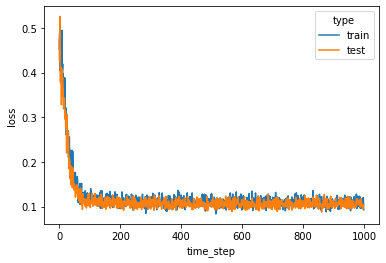

In [12]:
sns.lineplot(data=pd.DataFrame(entry), x='time_step', y='loss', hue='type')
pyplot.show()

We will now randomly pick a time slice and see how the model predicts the underlying causality.

In [13]:
simulation_sample = test.iloc[5]
positions = simulation_sample.trajectories.positions
velocities = simulation_sample.trajectories.velocity
energy = simulation_sample.trajectories.total_energy
edges = simulation_sample.trajectories.edges

batch = []
for time_step in range(0, 4):
    frames = [positions[time_step], velocities[time_step], energy[time_step]]
    result = pd.concat(frames)
    batch.append(result)
x = np.asarray([batch])

with torch.no_grad():
    predicted_causal_graph = m.predict(x)
    predicted_causal_graph = predicted_causal_graph.numpy()

    
print("\n---- predicted causal graph ----")
print(predicted_causal_graph)

print("\n---- actual causal graph ----")
print(edges[4])


---- predicted causal graph ----
[[[[0.48979878 0.46144268 0.42807838 0.4551678  0.46646988]
   [0.5057568  0.44382867 0.4181477  0.46478733 0.47171217]
   [0.45575774 0.4394899  0.43649554 0.4510693  0.43046185]
   [0.45523867 0.46651292 0.45111462 0.44673356 0.43295214]
   [0.4595755  0.4515774  0.4406985  0.4488802  0.4354466 ]]]]

---- actual causal graph ----
            particle_0  particle_1  particle_2  particle_3  particle_4
particle_0         0.0         0.7         0.0         0.5         0.7
particle_1         0.7         0.0         0.7         0.2         0.5
particle_2         0.0         0.7         0.0         0.5         0.7
particle_3         0.5         0.2         0.5         0.0         0.5
particle_4         0.7         0.5         0.7         0.5         0.0


## Conclusion

In this article we visited the concepts of causal graphs from time series data. We modeled a simple spring particle system to study its behaviour under granger causality. We built a simple linear regression based model to predict the underlying causality for a given particle dynamics over a period of times.